In [1]:
import torch
import torch.optim as optim
from torchvision import transforms 

import numpy as np
from PIL import Image
import requests
import copy
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
def plot_image(image_batch, title):
    display_image = image_batch[0].permute(1,2,0).numpy()
    
    plt.imshow(display_image)
    plt.title(title)
    plt.show()

In [3]:
def prepare_image(image):
    preprocessing = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        ])
    image = preprocessing(image)
    mini_batch = image.unsqueeze(0)
    
    return mini_batch

In [4]:
def postprocess_image(image_tensor):
    
    display_image = image_tensor[0]
    display_image = display_image.permute(1,2,0).detach().numpy()
    display_image *= 255
    display_image = display_image.astype(np.uint8)
    display_image = Image.fromarray(display_image, mode='RGB')

    return display_image 

## Prepare the Image of the "Snow Storm" by creating an array with every value being 255

/var/folders/w2/7k8xcq0x0r36wv03zdzfwd640000gn/T/ipykernel_47578/3792520591.py:5: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  snowstorm = Image.fromarray(snowstorm, mode='RGB')


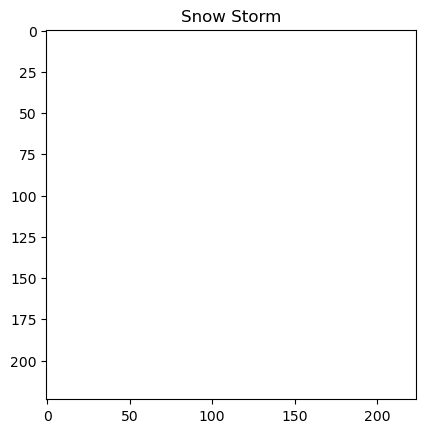

In [5]:
# Create an array of shape (height, width, 3) filled with 255 (white)
snowstorm = np.full((224, 224, 3), 255, dtype=np.uint8)

# Convert to PIL image
snowstorm = Image.fromarray(snowstorm, mode='RGB')

plt.title('Snow Storm')
plt.imshow(snowstorm);

## Prepare the Image of the "Snow Storm" by Resizing, Converting to a Tensor of Floating Point Values between 0 and 1, and Creating a Batch of 1 image

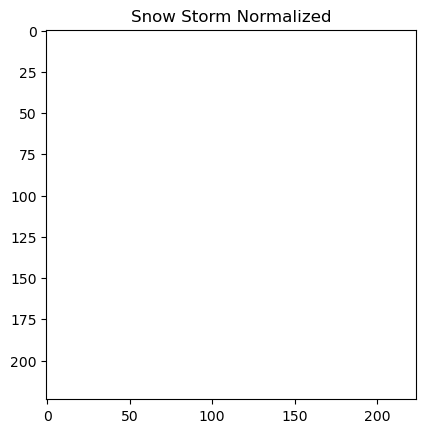

In [6]:
snowstorm = prepare_image(snowstorm)
plot_image(snowstorm, 'Snow Storm Normalized');

## Import the Image Classification Model and Infer upon the Prepared Image of the "Snow Storm"

In [7]:
mobilenetv2 = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=True).eval()
model_categories_url = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
model_categories = requests.get(model_categories_url).text.split('\n')

snowstorm_predictions = mobilenetv2(snowstorm)
snowstorm_predictions = torch.nn.functional.softmax(snowstorm_predictions, dim = 1) 

confidences, class_indicies = torch.sort(snowstorm_predictions, descending = True)
predicted_class = model_categories[class_indicies[0,0]]
print(f'{model_categories[class_indicies[0,0]]} with {confidences[0,0] : .4f} confidence')

Using cache found in /Users/asandhir/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/anaconda3/envs/py311_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


wall clock with  0.0101 confidence


## Create the target vector for CW to converge on

In [8]:
target_class = 'hare'
target = torch.Tensor([model_categories.index(target_class)]).int()

## Specify the Hyperparamters of the CW Algorithm

In [9]:
targeted = False
learning_rate = 0.01
initial_constant = 0.001
binary_search_steps = 9
max_itterations = 1000
confidence = 0 
abort_early = True

## Initalize the Variables Needed to Execute the CW Algorithm

In [72]:
batch_size = len(snowstorm)
batch_view = lambda tensor: tensor.view(batch_size,  *[1] * (snowstorm.dim() - 1))
tanh_inputs = torch.atanh((1 - 1e-6) * (2 * snowstorm - 1))
multiplier = -1

c = torch.full((batch_size, ), initial_constant)
lowerbound = torch.zeros_like(c)
upperbound = torch.full_like(c, 1e10)

overall_best_l2 = torch.full_like(c, torch.inf)
rabbit_in_snowstorm = snowstorm.clone()
rabbit_found = torch.zeros(batch_size, dtype = torch.bool)

predictions = mobilenetv2(snowstorm)
oh_labels = torch.zeros_like(predictions).scatter_(1, target.unsqueeze(1).long(), 1)
infh_labels = torch.zeros_like(predictions).scatter_(1, target.unsqueeze(1).long(), torch.inf)

best_i = 0
best_c = 0

## Execute the CW Algorithm

In [ ]:
for outer_step in range(binary_search_steps):
    modifier = torch.zeros_like(snowstorm, requires_grad = True)
    optimizer = optim.Adam([modifier], lr = learning_rate)
    best_l2_distance = torch.full_like(c, torch.inf)
    adv_found = torch.zeros(batch_size, dtype = torch.bool)

    previous_loss = torch.inf
    for i in trange(max_itterations, desc = f'c: {c[0].item(): .4f}'):
        adv_inputs = (torch.tanh(tanh_inputs + modifier) + 1)/2
        l2_squared = (adv_inputs - snowstorm).flatten(1).square().sum(1)
        l2_distance = l2_squared.detach().sqrt()
        logits = mobilenetv2.forward(adv_inputs)
        
        predicted_classes = (logits - (confidence * oh_labels)).argmax(1)
        adverserial = (predicted_classes == target) 
        
        is_smaller = l2_distance < best_l2_distance
        outer_is_smaller = l2_distance < overall_best_l2
        is_both = adverserial & is_smaller
        outer_is_both = adverserial & outer_is_smaller
        if outer_is_both:
            best_i = i
            best_c = c

        best_l2_distance = torch.where(is_both, l2_distance, best_l2_distance)
        adv_found.logical_or_(is_both)
        overall_best_l2 = torch.where(outer_is_both, l2_distance, overall_best_l2)
        rabbit_found.logical_or_(outer_is_both)
        rabbit_in_snowstorm = torch.where(batch_view(outer_is_both), adv_inputs.detach(), rabbit_in_snowstorm)
        
        class_logits = logits.gather(1, target.unsqueeze(1).long()).squeeze(1)
        other_logits = (logits - infh_labels).amax(dim = 1)
        logits_dist = multiplier * (class_logits - other_logits)
        loss = l2_squared + c * (logits_dist + confidence).clamp_(min = 0)

        if abort_early and (i % (max_itterations // 10) == 0):
            if (loss > previous_loss * .9999).all():
                break
            previous_loss = loss.detach()
        
        optimizer.zero_grad(set_to_none = None)
        modifier.grad = torch.autograd.grad(loss.sum(), modifier, only_inputs = True)[0]
        optimizer.step()

    upperbound[adv_found] = torch.min(upperbound[adv_found], c[adv_found])
    lowerbound[~adv_found] = torch.max(lowerbound[~adv_found], c[~adv_found])
    is_smaller = upperbound < 1e9
    c[is_smaller] = (lowerbound[is_smaller] + upperbound[is_smaller])/2
    c[(~is_smaller) & (~adv_found)] *= 10

rabbit_in_snowstorm_predictions = mobilenetv2.forward(rabbit_in_snowstorm)
rabbit_in_snowstorm_predictions = torch.nn.functional.softmax(rabbit_in_snowstorm_predictions, dim = 1) 
confidences, class_indicies = torch.sort(rabbit_in_snowstorm_predictions, descending = True)
prediction = model_categories[class_indicies[0, 0]]
plot_image(rabbit_in_snowstorm.detach(), f'{prediction} with {100 * confidences[0,0]: .4f}% confidence after {best_i} itterations at {best_c[0].item(): .4f}')


c:  1.0000:   7%|█▉                           | 66/1000 [00:21<04:58,  3.13it/s]

## Test Whether the Adverserial Perturbations Survive When Converted to a .png File

In [1]:
descritized_image = postprocess_image(rabbit_in_snowstorm)

descritized_predictions = mobilenetv2.forward(prepare_image(descritized_image))
descritized_predictions = torch.nn.functional.softmax(descritized_predictions, dim = 1) 
confidences, class_indicies = torch.sort(descritized_predictions, descending = True)

plt.imshow(descritized_image)
plt.title(f'{model_categories[class_indicies[0,0]]} with {100 * confidences[0,0]: .4f}% confidence');

NameError: name 'postprocess_image' is not defined